<a href="https://colab.research.google.com/github/JyothikaKanchu/NoiseRemovalfromAudioSignal/blob/main/noiseremovalfromaudiosignal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import IPython
import wave
import struct
import matplotlib.pyplot as plt

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
audiofile =  '/content/drive/MyDrive/noise-drum-loop-134bpm-245852.mp3'

In [41]:
IPython.display.Audio(audiofile)

In [42]:
!pip install pydub
from pydub import AudioSegment

In [43]:
file_extension = 'mp3'
track = AudioSegment.from_file(audiofile, file_extension)
audiofile_wave = audiofile.replace(file_extension, 'wav')
file_handle = track.export(audiofile_wave, format='wav')
print(audiofile_wave)

/content/drive/MyDrive/noise-drum-loop-134bpm-245852.wav


In [44]:
IPython.display.Audio(audiofile_wave)

In [45]:
from scipy import fftpack

wav_file = wave.open(audiofile_wave, 'r')
nchannels, sampwidth, framerate, nframes, comptype, compname = wav_file.getparams()
print("Params:", "\n\tChannel:", nchannels, "\n\tSample Width:", sampwidth, "\n\tFramerate:", framerate, "\n\tNumber of Frames:", nframes, "\n\tcomptype:", comptype, "\n\tCompname:", compname)

# Reading wave format data from wav file.
frames_wave = wav_file.readframes(nframes)
wav_file.close()

print("Length:", nframes)
# Deserializing the raw bytes into 16-bit signed integers (2 bytes per sample)
frames_wave = struct.unpack('{n}h'.format(n=nframes * nchannels), frames_wave)
frames_wave = np.array(frames_wave)
print("Min value:", np.min(frames_wave), "Max value:", np.max(frames_wave))

Params: 
	Channel: 2 
	Sample Width: 2 
	Framerate: 44100 
	Number of Frames: 317952 
	comptype: NONE 
	Compname: not compressed
Length: 317952
Min value: -32768 Max value: 32767


In [46]:
# Fast Fourier Transform
# frames_freq_domian = np.fft.fft(frames_wave)
frames_freq_domian = fftpack.fft(frames_wave)

# Above value is in complex number but we want absolute number
# This will give us the frequency we want
magnitude = np.abs(frames_freq_domian)  # Or ampliude ?
phase = np.angle(frames_freq_domian) # Normally we are not interested in phase information, its only used in reconstruction.

print(magnitude.shape, phase.shape)
print("The max frequency (highest magnitude) is {} Hz".format(np.where(magnitude == np.max(magnitude))[0][0]))

(635904,) (635904,)
The max frequency (highest magnitude) is 612 Hz


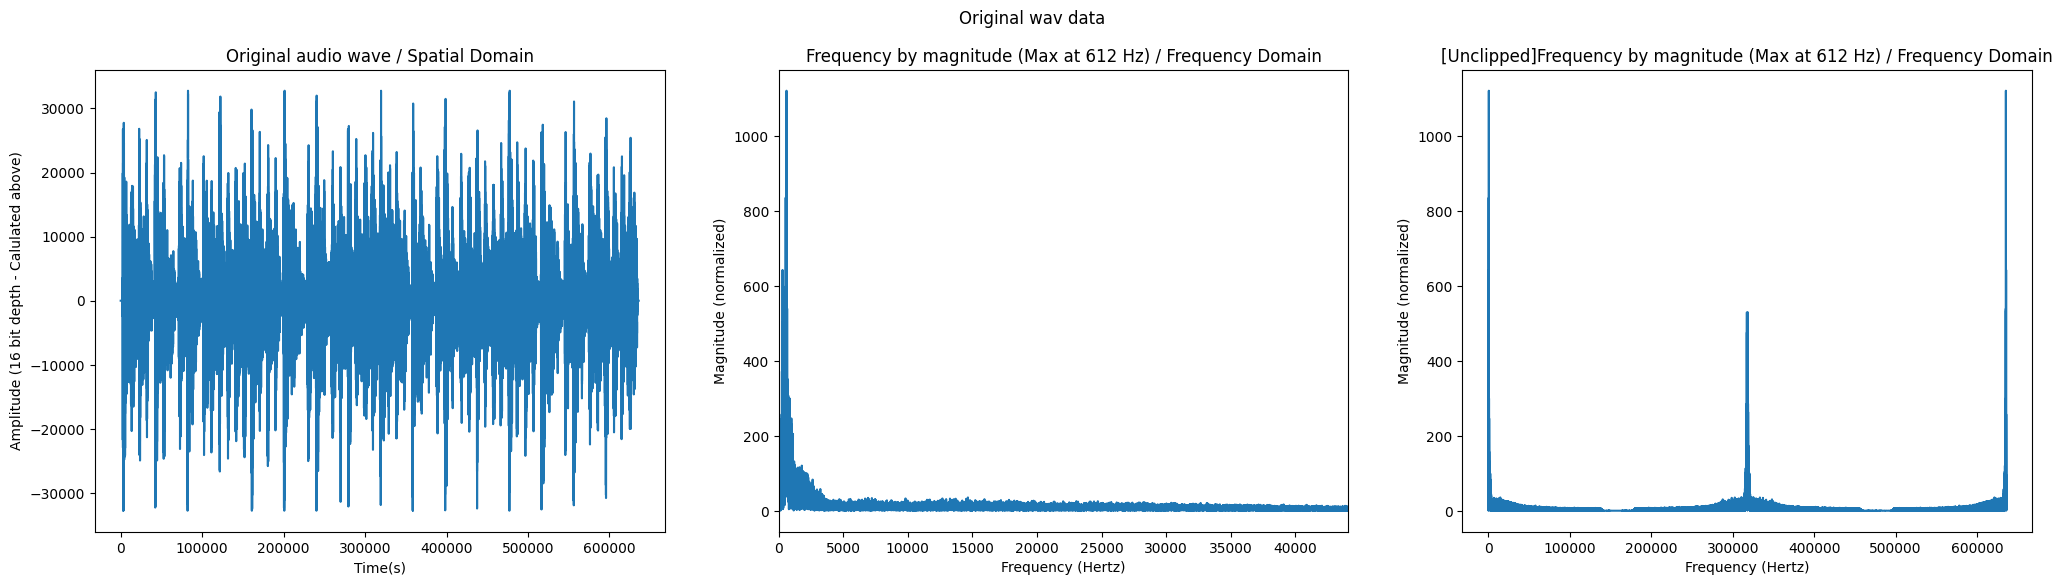

In [47]:
fig = plt.figure(figsize = (25, 6))
fig.suptitle('Original wav data')

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Original audio wave / Spatial Domain")
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Amplitude (16 bit depth - Calulated above)")

ax1.plot(frames_wave)

ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Frequency by magnitude (Max at {} Hz) / Frequency Domain".format(np.where(magnitude == np.max(magnitude))[0][0]))
ax2.set_xlabel("Frequency (Hertz)")
ax2.set_ylabel("Magnitude (normalized)")
ax2.set_xlim(0, 44100)  # we are not interested in rest
ax2.plot(magnitude / nframes)  # Normalizing magnitude

ax3 = fig.add_subplot(1,3,3)
ax3.set_title("[Unclipped]Frequency by magnitude (Max at {} Hz) / Frequency Domain".format(np.where(magnitude == np.max(magnitude))[0][0]))
ax3.set_xlabel("Frequency (Hertz)")
ax3.set_ylabel("Magnitude (normalized)")
ax3.plot(magnitude / nframes)  # Normalizing magnitude

plt.show()

normal_cutoff: 0.04081632653061224 12977.632653061224


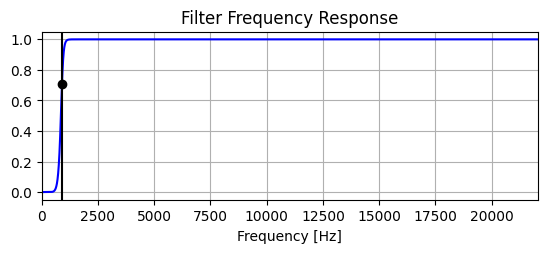

(635904,) (635904,) False


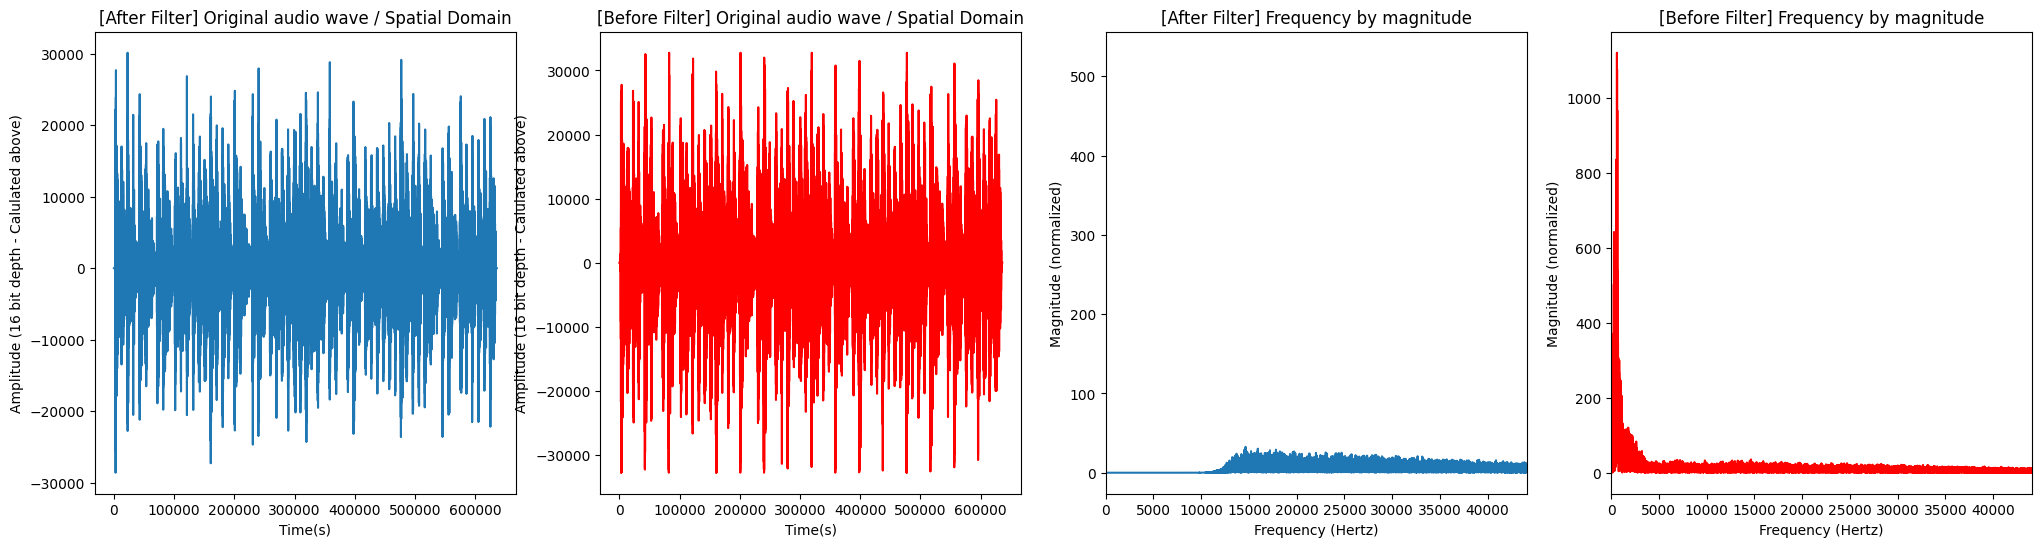

In [48]:
from scipy import signal
from matplotlib import pyplot as plt

def butter_pass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs # Nyquist frequency
    normal_cutoff = cutoff / nyq  # A fraction b/w 0 and 1 of sampling rate
    print("normal_cutoff:", normal_cutoff, (data.shape[0] / 2) * normal_cutoff) # Tricky ?
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)

    def _plot_graph():
      # Get the filter coefficients so we can check its frequency response.
      # Plot the frequency response.
      w, h = signal.freqz(b, a, worN=8000)
      plt.subplot(2, 1, 1)
      plt.plot(0.5 *fs*w/np.pi, np.abs(h), 'b')
      plt.plot(cutoff, 0.5 * np.sqrt(2), 'ko')
      plt.axvline(cutoff, color='k')
      plt.xlim(0, 0.5*fs)
      plt.title("Filter Frequency Response")
      plt.xlabel('Frequency [Hz]')
      plt.grid()
      plt.show()
    _plot_graph()
    return y

# Filter requirements.
order = 10
fs = framerate #* 6.28  # sample rate, Hz
cutoff =  900 #* 6.28      # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
y = butter_pass_filter(frames_wave, cutoff, fs, order)

print(frames_wave.shape, y.shape, np.array_equal(frames_wave, y))
fig = plt.figure(figsize = (25, 6))
# fig.suptitle('Horizontally stacked subplots')

ax1 = fig.add_subplot(1,4,1)
ax1.set_title("[After Filter] Original audio wave / Spatial Domain")
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Amplitude (16 bit depth - Calulated above)")
ax1.plot(y)

ax2 = fig.add_subplot(1,4,2)
ax2.set_title("[Before Filter] Original audio wave / Spatial Domain")
ax2.set_xlabel("Time(s)")
ax2.set_ylabel("Amplitude (16 bit depth - Calulated above)")
ax2.plot(frames_wave, 'r')


m = np.abs(fftpack.fft(y))
ax3 = fig.add_subplot(1,4,3)
ax3.set_title("[After Filter] Frequency by magnitude")
ax3.set_xlabel("Frequency (Hertz)")
ax3.set_ylabel("Magnitude (normalized)")
ax3.set_xlim(0, 44100)  # we are not interested in rest
ax3.plot(np.abs(fftpack.fft(y)) / nframes)
# ax2.plot(range(0, 676864), m, 'g-', label='dataa')


ax4 = fig.add_subplot(1,4,4)
ax4.set_title("[Before Filter] Frequency by magnitude")
ax4.set_xlabel("Frequency (Hertz)")
ax4.set_ylabel("Magnitude (normalized)")
ax4.set_xlim(0, 44100)  # we are not interested in rest
# ax2.plot(magnitude * 2 / (16 * len(magnitude)))
ax4.plot(magnitude / nframes, 'r')

plt.show()
IPython.display.Audio(data=y, rate=44100)

In [49]:
amplitude = 1
filtered_file = "/content/drive/MyDrive/noise-drum-loop-134bpm-245852.wav"
wav_file=wave.open(filtered_file, 'w')
# The tuple should be (nchannels, sampwidth, framerate, nframes, comptype, compname)
wav_file.setparams((nchannels, sampwidth, framerate, nframes, "NONE", "not compressed"))

#Struct is a Python library that takes our data and packs it as binary data. The h in the code means 16 bit number.
for s in y:
    wav_file.writeframes(struct.pack('h', int(s*amplitude)))

wav_file.close()
IPython.display.Audio(filtered_file)